# from noAdolescence to the final training dataset for the classifiers
In this notebook, I summarize all the steps taken to transition from the dataset produced by the iterative application of the cytograph pipeline to the final dataset used for training the Random Forest and Mahalanobis distance-based classifiers. Although this notebook outlines every step involved, the actual analyses were performed in separate notebooks, and the resulting data was then used here.
I will reference the notebook used to generate the data imported at each step for reproducibility.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(7, 4))
sc.settings.verbosity = 3

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
bottleneck                  1.3.7
brotli                      1.0.9
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.10.0
cython_runtime              NA
dask                        2024.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
id

### Importing noAdolescence

In [3]:
adata = sc.read_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/proj/GBM/output/data/Velmeshev_Braun_Wang_Neuroepithelial_Forebrain_NoNeuronOligo_Cortex_NoNeuronOligo_NoAdolescence.h5ad')

## Step 1: some initial adjustments

#### checking if the dataset contains duplicated genes

In [4]:
print("Duplicates after renaming names in adata:", pd.Series(adata.var_names).duplicated().any())

Duplicates after renaming names in adata: False


#### Changing index from gene endemble IDs to gene namesThis is more convenient since we used gene names throughout all the analyses

In [5]:
adata.var = (
    adata.var
    .reset_index()                      
    .rename(columns={'index': 'ensemble_ids'})  
    .set_index('Gene')                  
)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['LINC00115', 'FAM41C', 'NOC2L', 'HES4', 'RNF223']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


#### Setting the column 'Clusters' as categorical, for an easier visualization on the UMAP

In [6]:
adata.obs['Clusters'] = adata.obs['Clusters'].astype('category')

## Step 2: removing cycling cells
We removed the cycling cells identified by the cytograph pipeline; many of these cells clustered in cluster 11.

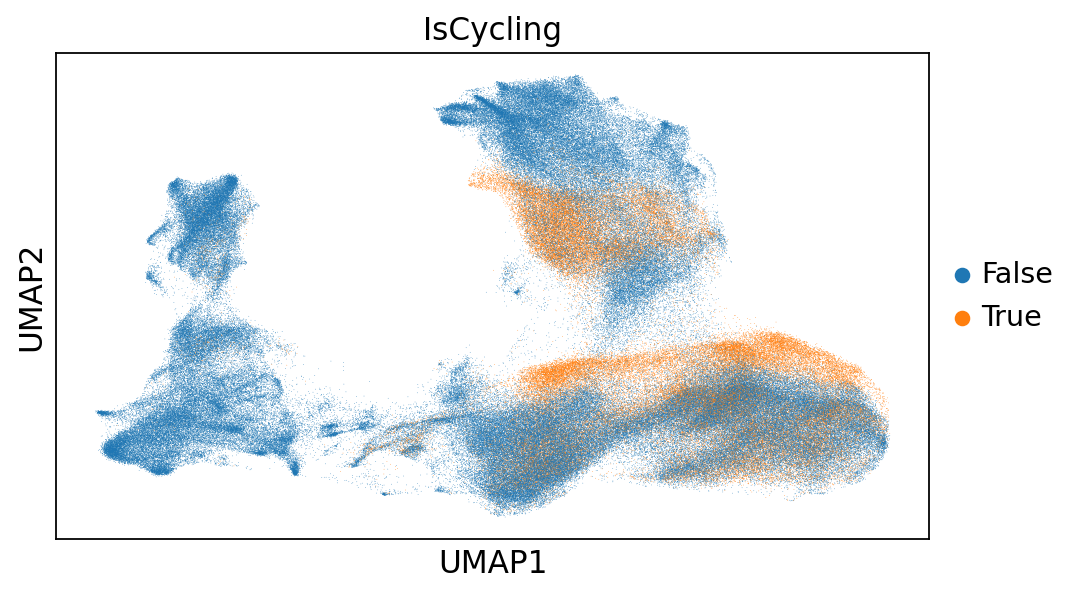

In [7]:
sc.pl.embedding(adata, basis = 'UMAP', color = 'IsCycling')

In [8]:
adata = adata[adata.obs['IsCycling'] == False]

In [9]:
#adata.write_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/noAdolescence_nocc.h5ad')

After saving the anndata object from the initial step as `noAdolescence_nocc.h5ad`, I used it to perform a differential expression analysis in another notebook and ultimately annotate the dataset.

## Step 3: Manual annotation and filtering
During this analysis performed in notebook `DEA_of_cytograph_clusters.ipynb`, clusters 2, 3, 15, and 11 emerged as ambiguous, so we decided to remove them.

#### First, I removed the ambiguous clusters

In [10]:
adata = adata[~adata.obs.Clusters.isin([2, 3, 15, 11])]

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


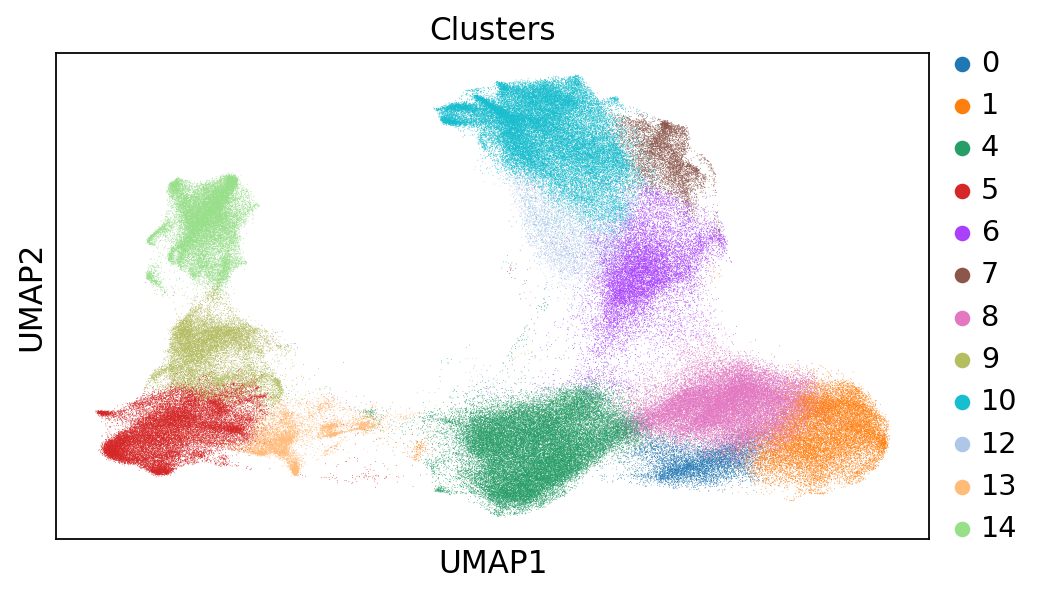

In [11]:
sc.pl.embedding(adata, basis = 'UMAP', color = 'Clusters')

#### Then I annotated the dataset, and saved the new labels into the column FirstManualAnnotations

In [12]:
cluster_to_annotation = {
    0: 'early Radial Glia',
    1: 'early Radial Glia',
    8: 'early Radial Glia',
    4: 'late Radial Glia',
    13: 'Astrocytes',
    5: 'Astrocytes',
    9: 'gIPCs',
    14: 'OPCs',
    6: 'nIPCs',
    12: 'nIPCs',
    7: 'nIPCs',
    10: 'nIPCs'
}

adata.obs['FirstManualAnnotations'] = adata.obs['Clusters'].map(cluster_to_annotation)

In [13]:
#adata.write_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/noAdolescence_nocc_noclusters_FirstManualAnnotations.h5ad')

I saved the updated training dataset as `noAdolescence_nocc_noclusters_FirstManualAnnotations.h5ad`. We then decided to perform a deeper analysis of cluster 9 because its UMAP representation suggested it contained some astrocytic cells, in notebook `gIPC_reannotation_no_astro_and_Figure_7_E_F.ipynb`. I also decided to perform a parallel integration and clustering analysis of this dataset in notebook `clustering_analysis_scanpy_noAdolescence.ipynb`

## Step 4: reannotating cluster 9 – distinguishing between gIPCs and Astrocytes
To accomplish this, I loaded the CSV file `Cluster9Reannotation.csv` containing the new annotations that I generated in the`gIPC_reannotation_no_astro_and_Figure_7_E_F.ipynb`` notebook, where I performed the analysis. Then, I reannotated the anndata object.s.

In [14]:
new_annotations_9 = pd.read_csv('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/Cluster9Reannotation.csv', index_col=0)

#### I created an additional variable, the column SecondManualAnnotations, to store the new annotations.
I decided to retain the previous annotations as well, so that no information is lost and we can compare the two sets of annotations if needed.

In [15]:
adata.obs['SecondManualAnnotations'] = adata.obs['FirstManualAnnotations'].copy()
adata.obs.loc[new_annotations_9.index, 'SecondManualAnnotations'] = new_annotations_9.loc[new_annotations_9.index, 'Cluster9Reannotation']

In [16]:
adata.obs['SecondManualAnnotations'].value_counts()

SecondManualAnnotations
nIPCs                66389
early Radial Glia    54535
late Radial Glia     39861
Astrocytes           38143
OPCs                 20927
gIPCs                10129
Name: count, dtype: int64

In [17]:
#adata.write_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/noAdolescence_nocc_noclusters_SecondManualAnnotations.h5ad')

I saved the resulting anndata object as `noAdolescence_nocc_noclusters_SecondManualAnnotations.h5ad`. I then performed another clustering analysis on this dataset to subdivide gIPCs into pre-OPCs and pre-Astrocytes.

## Step 5: splitting the annotation of gIPCs – distinguishing between pre-OPCs and pre-Astrocytes
To do this, I loaded the CSV file `GIPCsDivisionReannotation.csv`, which contains the updated annotations generated in the `gIPC_reannotation_after_removing_astro.ipynb` notebook. I then applied these new annotations to the anndata object.s.

In [18]:
new_annotations_gIPCs = pd.read_csv('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/GIPCsDivisionReannotation.csv', index_col = 0)

In [19]:
adata.obs['ThirdManualAnnotations'] = adata.obs['SecondManualAnnotations'].copy()
adata.obs['ThirdManualAnnotations'] = adata.obs['ThirdManualAnnotations'].astype('category')
adata.obs['ThirdManualAnnotations'] = adata.obs['ThirdManualAnnotations'].cat.add_categories(new_annotations_gIPCs['GIPCsDivisionReannotation'].unique())
adata.obs.loc[new_annotations_gIPCs.index, 'ThirdManualAnnotations'] = new_annotations_gIPCs.loc[new_annotations_gIPCs.index, 'GIPCsDivisionReannotation']



#### After this step, I removed the empty 'gIPCs' label from this variable as well as the cycling cells, useless for our task.

In [20]:
adata = adata[adata.obs.ThirdManualAnnotations != 'gIPCs']
adata = adata[adata.obs.ThirdManualAnnotations != 'Cycling']

In [21]:
#adata.write_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/noAdolescence_nocc_noclusters_ThirdManualAnnotations.h5ad')

I saved the resulting anndata object as `noAdolescence_nocc_noclusters_ThirdManualAnnotations.h5ad`. We then decided to add some subcortical nIPCs from the Braun dataset.

## Step 6: adding Subcortical nIPCs  
I imported the subcortical nIPCs selected in the `extracting_interneurons.ipynb` notebook and concatenated them with the current version of `adata`.

In [22]:
interneurons = sc.read_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/braun_subcortical.h5ad')

**Note**: In the report, I included the following step, and the subsequent analyses were based on the training dataset version that incorporated it. However, I plan to remove this step because it significantly reduces the number of pre-OPCs and pre-Astrocytes, and I don't think it's worthwhile. To reproduce the exact results described in the report, please uncomment the following cell.

In [23]:
#adata = adata[adata.obs.NGenes > 1000, :]
#sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=3)

#### I retained only the common genes to avoid issues later on.

In [24]:
commonGenes = np.intersect1d(adata.var_names, interneurons.var_names)
adata = adata[:, commonGenes]
interneurons = interneurons[:, commonGenes]

#### Some cells overlapped between the two anndata objects because `adata` is a concatenation of three datasets, including Braun. I removed these overlapping cells to avoid duplicates.

In [25]:
adata = adata[~adata.obs_names.isin(interneurons.obs_names.intersection(adata.obs_names))].copy()

#### Concatenation

In [26]:
to_concatenate = [interneurons, adata]
adata = ad.concat(to_concatenate, join='outer', label='interneurons')

In [27]:
adata.obs.ThirdManualAnnotations.value_counts()

ThirdManualAnnotations
nIPCs                64841
early Radial Glia    54535
late Radial Glia     39861
Astrocytes           38141
OPCs                 20927
Subcortical nIPCs    13149
pre-Astrocytes        3071
pre-OPCs              2722
Name: count, dtype: int64

#### Final quality controls

In [29]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

In [34]:
print(np.median(adata.obs['total_counts']))
print(np.median(adata.obs['pct_counts_mt']))

2399.0
0.9964641594342655


#### Uncomment and run this to save the final training dataset.

In [35]:
#adata.write_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/noAdolescence_nocc_noclusters_ThirdManualAnnotations_Interneurons.h5ad')